In [ ]:
import pandas as pd
import random
import numpy as np
from random import randint
import torch
from transformers import AutoTokenizer, AutoModel
import gc

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import time
import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [ ]:
torch.__version__

'2.5.0+cu124'

In [ ]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.legacy.model_stuff import (
    fix_all_seeds,
    train_loop,
    train_loop_modified_scale,
)
from text_embeddings_src.data_stuff import (
    MultOverlappingSentencesPairDataset,
    MaskedMultOverlappingSentencesPairDataset,
    SameSentencePairDataset
)

In [ ]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [ ]:
variables_path = Path("../../results/variables")
figures_path = Path("../../results/figures/updated_dataset")
data_path = Path("../../data")

In [ ]:
# MANUAL FIX TO PATH ISSUE FROM VSCODE
import text_embeddings_src

nb_path = Path(text_embeddings_src.__path__[0]).parents[0] / Path(
    "scripts/updated_dataset"
)
assert nb_path.exists(), "The path does not exist"

variables_path = (nb_path / variables_path).resolve(strict=True)
figures_path = (nb_path / figures_path).resolve(strict=True)
data_path = (nb_path / data_path).resolve(strict=True)

In [ ]:
plt.style.use((nb_path / Path("../matplotlib_style.txt")).resolve(strict=True))

In [ ]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers,openTSNE
print(distro.name(pretty=True))

Author: Rita González-Márquez

Last updated: 2024-11-20 10:16:29CET

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.28.0

transformers: 4.45.2
openTSNE    : 1.0.2

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.18.0-553.el8_10.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

distro             : 1.9.0
jupyter_black      : 0.4.0
matplotlib         : 3.9.2
torch              : 2.5.0
transformers       : 4.45.2
memory_profiler    : 0.61.0
text_embeddings_src: 0.0.0
pandas             : 2.2.3
numpy              : 1.26.4
black              : 24.10.0

Watermark: 2.5.0

Ubuntu 24.04 LTS


# Import

In [ ]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    engine="pyarrow",
)

CPU times: user 274 ms, sys: 75.6 ms, total: 350 ms
Wall time: 262 ms


In [ ]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [ ]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [ ]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

pickle_in = open(
    variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
)
dict_label_to_color = pickle.load(pickle_in)

# Temperature

for both AV and CLS

Optimize the [av] representation for BERT. batch_size=64, lr=2e-5.

Now using the multi sentence data augmentation (MultOverlappingSentencesPairDataset), with n_cons_sntcs=2.

Experiment in which I vary the scale (inverse of temperature).

In [ ]:
model_names = [
    "BERT",
    "MPNet",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
]

## [CLS]

In [ ]:
%%time

multipliers = np.array([0.01, 0.1, 1, 10])
for j, mult in enumerate(multipliers):
    print(f"Scale = 20 * {mult}")
    # model
    i = 1
    model_name = model_names[i]

    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop_modified_scale(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="cls",
        n_epochs=1,
        lr=2e-5,
        scale_multiplier=mult,
        return_seventh=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)
    saving_name_losses = Path(f"losses_cls_scale_multiplier_{mult}" + "_v1")
    saving_name_accuracies = Path(
        f"knn_accuracies_cls_scale_multiplier_{mult}" + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Scale = 20 * 0.01
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 0.1
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 1.0
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 10.0
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 35min 11s, sys: 31min 20s, total: 1h 6min 31s
Wall time: 35min 58s


### Plot

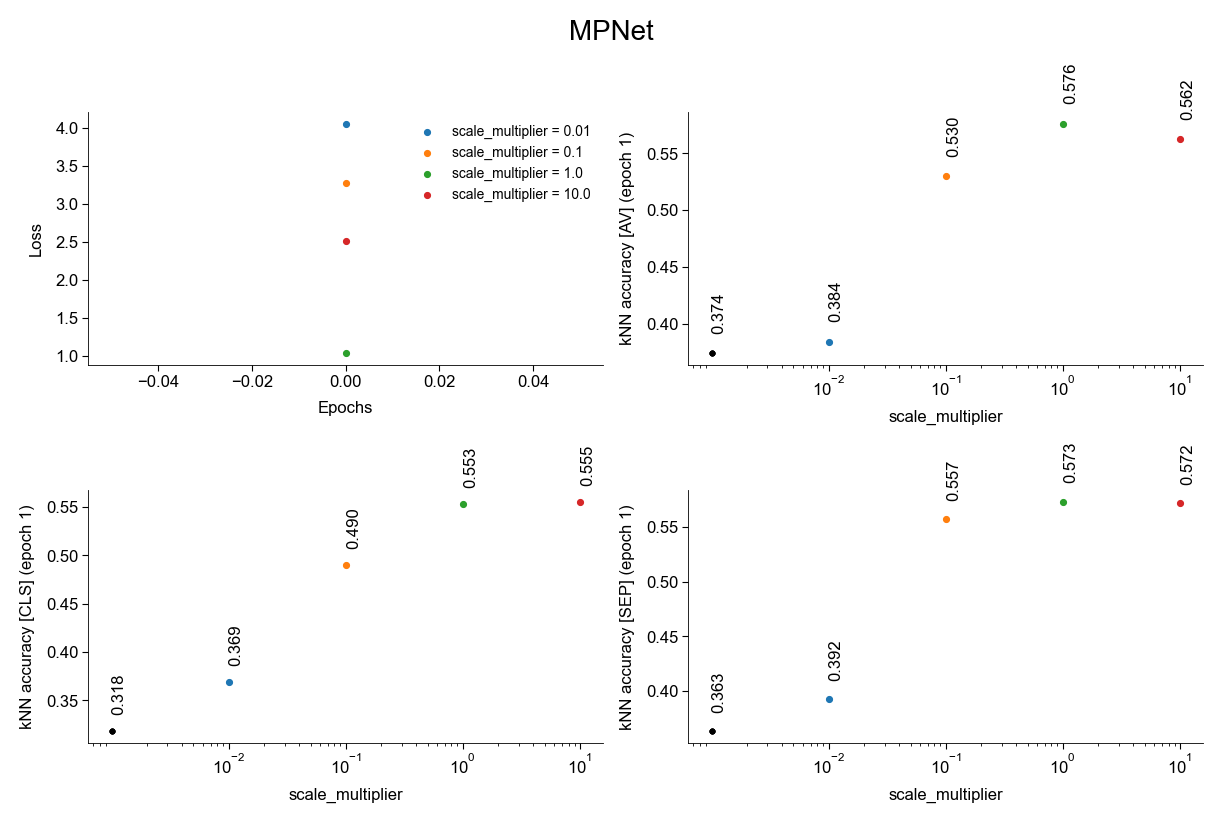

In [ ]:
%matplotlib inline

# for i, model_name in enumerate(model_names):
fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 1
colormap = plt.get_cmap("tab10")
multipliers = np.array([0.01, 0.1, 1, 10])
for j, mult in enumerate(multipliers):
    i = 1
    model_name = model_names[i]

    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    saving_name_losses = Path(
        f"losses_cls_scale_multiplier_{mult}" + "_v1.npy"
    )
    saving_name_accuracies = Path(
        f"knn_accuracies_cls_scale_multiplier_{mult}" + "_v1.npy"
    )

    losses = np.load(variables_path / saving_path / saving_name_losses)
    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    saving_name_2 = Path(
        "updated_dataset/knn_accuracy_" + model_name.lower() + ".npy"
    )
    knn_acc_highd = np.load(variables_path / saving_name_2)

    ## plot
    color = colormap(j)

    # loss
    axs[0, 0].scatter(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )

    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xscale("linear")
    axs[0, 0].legend()

    # AV
    axs[0, 1].scatter(
        mult,
        knn_accuracies[-1, 0],
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )
    axs[0, 1].text(
        mult,
        knn_accuracies[-1, 0] + 0.02,
        f"{knn_accuracies[-1, 0]:.3f}",
        rotation="vertical",
        fontsize=6,
    )

    axs[0, 1].scatter(0.001, knn_acc_highd[0], s=5, c="k")
    if j == 0:
        axs[0, 1].text(
            0.001,
            knn_acc_highd[0] + 0.02,
            f"{knn_acc_highd[0]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    # axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("scale_multiplier")
    axs[0, 1].set_xscale("log")
    axs[0, 1].set_xticks(multipliers)
    axs[0, 1].set_ylabel("kNN accuracy [AV] (epoch 1)")

    # CLS
    axs[1, 0].scatter(
        mult,
        knn_accuracies[-1, 1],
        s=10,
        label=f"scale_multiplier = {mult}",
        color=color,
    )
    axs[1, 0].text(
        mult,
        knn_accuracies[-1, 1] + 0.02,
        f"{knn_accuracies[-1, 1]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[1, 0].scatter(0.001, knn_acc_highd[1], s=5, c="k")
    if j == 0:
        axs[1, 0].text(
            0.001,
            knn_acc_highd[1] + 0.02,
            f"{knn_acc_highd[1]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    # axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("scale_multiplier")
    axs[1, 0].set_xscale("log")
    axs[1, 0].set_xticks(multipliers)
    axs[1, 0].set_ylabel("kNN accuracy [CLS] (epoch 1)")

    # SEP
    axs[1, 1].scatter(
        mult,
        knn_accuracies[-1, 2],
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )
    axs[1, 1].text(
        mult,
        knn_accuracies[-1, 2] + 0.02,
        f"{knn_accuracies[-1, 2]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[1, 1].scatter(0.001, knn_acc_highd[2], s=5, c="k")
    if j == 0:
        axs[1, 1].text(
            0.001,
            knn_acc_highd[2] + 0.02,
            f"{knn_acc_highd[2]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    # axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("scale_multiplier")
    axs[1, 1].set_xscale("log")
    axs[1, 1].set_xticks(multipliers)
    axs[1, 1].set_ylabel("kNN accuracy [SEP] (epoch 1)")

fig.suptitle(f"{model_name}", fontsize=10)

fig.savefig(
    figures_path
    / f"loss_and_knn_accuracy_cls_scale_multiplier_{model_name}_v1.png"
)

## [AV]

In [ ]:
%%time

multipliers = np.array([0.01, 0.1, 1, 10])
for j, mult in enumerate(multipliers):
    print(f"Scale = 20 * {mult}")
    # model
    i = 1
    model_name = model_names[i]

    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop_modified_scale(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=1,
        lr=2e-5,
        scale_multiplier=mult,
        return_seventh=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)
    saving_name_losses = Path(f"losses_av_scale_multiplier_{mult}" + "_v1")
    saving_name_accuracies = Path(
        f"knn_accuracies_av_scale_multiplier_{mult}" + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Scale = 20 * 0.01
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 0.1
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 1.0
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 10.0
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 36min 39s, sys: 31min 30s, total: 1h 8min 10s
Wall time: 36min 11s


### Plot

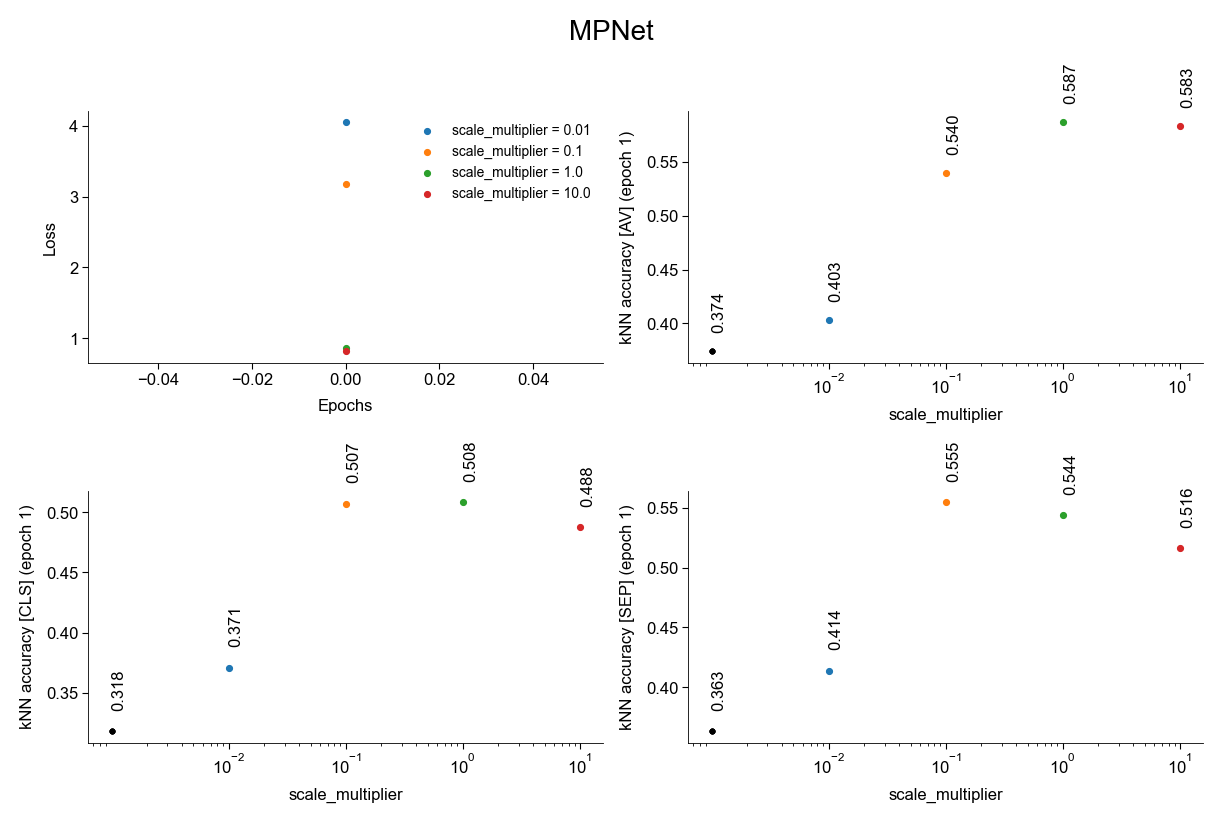

In [ ]:
%matplotlib inline

# for i, model_name in enumerate(model_names):
fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 1
colormap = plt.get_cmap("tab10")
multipliers = np.array([0.01, 0.1, 1, 10])
for j, mult in enumerate(multipliers):
    i = 1
    model_name = model_names[i]

    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    saving_name_losses = Path(f"losses_av_scale_multiplier_{mult}" + "_v1.npy")
    saving_name_accuracies = Path(
        f"knn_accuracies_av_scale_multiplier_{mult}" + "_v1.npy"
    )

    losses = np.load(variables_path / saving_path / saving_name_losses)
    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    saving_name_2 = Path(
        "updated_dataset/knn_accuracy_" + model_name.lower() + ".npy"
    )
    knn_acc_highd = np.load(variables_path / saving_name_2)

    ## plot
    color = colormap(j)

    # loss
    axs[0, 0].scatter(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )

    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].set_xscale("linear")
    axs[0, 0].legend()

    # AV
    axs[0, 1].scatter(
        mult,
        knn_accuracies[-1, 0],
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )
    axs[0, 1].text(
        mult,
        knn_accuracies[-1, 0] + 0.02,
        f"{knn_accuracies[-1, 0]:.3f}",
        rotation="vertical",
        fontsize=6,
    )

    axs[0, 1].scatter(0.001, knn_acc_highd[0], s=5, c="k")
    if j == 0:
        axs[0, 1].text(
            0.001,
            knn_acc_highd[0] + 0.02,
            f"{knn_acc_highd[0]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    # axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("scale_multiplier")
    axs[0, 1].set_xscale("log")
    axs[0, 1].set_xticks(multipliers)
    axs[0, 1].set_ylabel("kNN accuracy [AV] (epoch 1)")

    # CLS
    axs[1, 0].scatter(
        mult,
        knn_accuracies[-1, 1],
        s=10,
        label=f"scale_multiplier = {mult}",
        color=color,
    )
    axs[1, 0].text(
        mult,
        knn_accuracies[-1, 1] + 0.02,
        f"{knn_accuracies[-1, 1]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[1, 0].scatter(0.001, knn_acc_highd[1], s=5, c="k")
    if j == 0:
        axs[1, 0].text(
            0.001,
            knn_acc_highd[1] + 0.02,
            f"{knn_acc_highd[1]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    # axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("scale_multiplier")
    axs[1, 0].set_xscale("log")
    axs[1, 0].set_xticks(multipliers)
    axs[1, 0].set_ylabel("kNN accuracy [CLS] (epoch 1)")

    # SEP
    axs[1, 1].scatter(
        mult,
        knn_accuracies[-1, 2],
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )
    axs[1, 1].text(
        mult,
        knn_accuracies[-1, 2] + 0.02,
        f"{knn_accuracies[-1, 2]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[1, 1].scatter(0.001, knn_acc_highd[2], s=5, c="k")
    if j == 0:
        axs[1, 1].text(
            0.001,
            knn_acc_highd[2] + 0.02,
            f"{knn_acc_highd[2]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    # axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("scale_multiplier")
    axs[1, 1].set_xscale("log")
    axs[1, 1].set_xticks(multipliers)
    axs[1, 1].set_ylabel("kNN accuracy [SEP] (epoch 1)")

fig.suptitle(f"{model_name}", fontsize=10)

fig.savefig(
    figures_path
    / f"loss_and_knn_accuracy_av_scale_multiplier_{model_name}_v1.png"
)

## [SEP]

In [ ]:
%%time

multipliers = np.array([0.01, 0.1, 1, 10])
for j, mult in enumerate(multipliers):
    print(f"Scale = 20 * {mult}")
    # model
    i = 1
    model_name = model_names[i]

    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop_modified_scale(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="sep",
        n_epochs=1,
        lr=2e-5,
        scale_multiplier=mult,
        return_seventh=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)
    saving_name_losses = Path(f"losses_sep_scale_multiplier_{mult}" + "_v1")
    saving_name_accuracies = Path(
        f"knn_accuracies_sep_scale_multiplier_{mult}" + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Scale = 20 * 0.01
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 0.1
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 1.0
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 10.0
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 35min 47s, sys: 31min 16s, total: 1h 7min 4s
Wall time: 36min 16s


### Plot

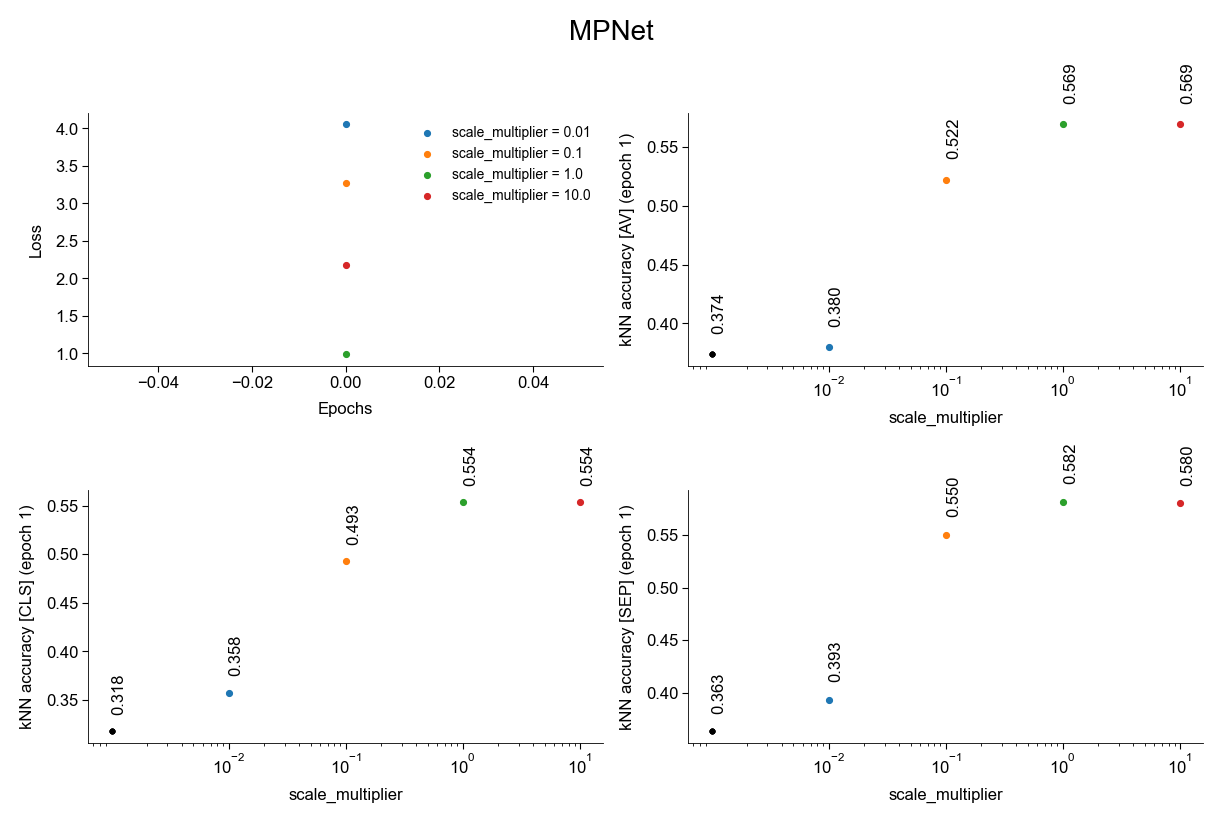

In [ ]:
%matplotlib inline

# for i, model_name in enumerate(model_names):
fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 1
colormap = plt.get_cmap("tab10")
multipliers = np.array([0.01, 0.1, 1, 10])
for j, mult in enumerate(multipliers):
    i = 1
    model_name = model_names[i]

    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    saving_name_losses = Path(
        f"losses_sep_scale_multiplier_{mult}" + "_v1.npy"
    )
    saving_name_accuracies = Path(
        f"knn_accuracies_sep_scale_multiplier_{mult}" + "_v1.npy"
    )

    losses = np.load(variables_path / saving_path / saving_name_losses)
    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    saving_name_2 = Path(
        "updated_dataset/knn_accuracy_" + model_name.lower() + ".npy"
    )
    knn_acc_highd = np.load(variables_path / saving_name_2)

    ## plot
    color = colormap(j)

    # loss
    axs[0, 0].scatter(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )

    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xscale("linear")
    axs[0, 0].legend()

    # AV
    axs[0, 1].scatter(
        mult,
        knn_accuracies[-1, 0],
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )
    axs[0, 1].text(
        mult,
        knn_accuracies[-1, 0] + 0.02,
        f"{knn_accuracies[-1, 0]:.3f}",
        rotation="vertical",
        fontsize=6,
    )

    axs[0, 1].scatter(0.001, knn_acc_highd[0], s=5, c="k")
    if j == 0:
        axs[0, 1].text(
            0.001,
            knn_acc_highd[0] + 0.02,
            f"{knn_acc_highd[0]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    # axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("scale_multiplier")
    axs[0, 1].set_xscale("log")
    axs[0, 1].set_xticks(multipliers)
    axs[0, 1].set_ylabel("kNN accuracy [AV] (epoch 1)")

    # CLS
    axs[1, 0].scatter(
        mult,
        knn_accuracies[-1, 1],
        s=10,
        label=f"scale_multiplier = {mult}",
        color=color,
    )
    axs[1, 0].text(
        mult,
        knn_accuracies[-1, 1] + 0.02,
        f"{knn_accuracies[-1, 1]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[1, 0].scatter(0.001, knn_acc_highd[1], s=5, c="k")
    if j == 0:
        axs[1, 0].text(
            0.001,
            knn_acc_highd[1] + 0.02,
            f"{knn_acc_highd[1]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    # axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("scale_multiplier")
    axs[1, 0].set_xscale("log")
    axs[1, 0].set_xticks(multipliers)
    axs[1, 0].set_ylabel("kNN accuracy [CLS] (epoch 1)")

    # SEP
    axs[1, 1].scatter(
        mult,
        knn_accuracies[-1, 2],
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )
    axs[1, 1].text(
        mult,
        knn_accuracies[-1, 2] + 0.02,
        f"{knn_accuracies[-1, 2]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[1, 1].scatter(0.001, knn_acc_highd[2], s=5, c="k")
    if j == 0:
        axs[1, 1].text(
            0.001,
            knn_acc_highd[2] + 0.02,
            f"{knn_acc_highd[2]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    # axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("scale_multiplier")
    axs[1, 1].set_xscale("log")
    axs[1, 1].set_xticks(multipliers)
    axs[1, 1].set_ylabel("kNN accuracy [SEP] (epoch 1)")

fig.suptitle(f"{model_name}", fontsize=10)

fig.savefig(
    figures_path
    / f"loss_and_knn_accuracy_sep_scale_multiplier_{model_name}_v1.png"
)

## [7th]

In [ ]:
%%time

multipliers = np.array([0.01, 0.1, 1, 10])
for j, mult in enumerate(multipliers):
    print(f"Scale = 20 * {mult}")
    # model
    i = 1
    model_name = model_names[i]

    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2, seed=42
    )

    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop_modified_scale(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="7th",
        n_epochs=1,
        lr=2e-5,
        scale_multiplier=mult,
        return_seventh=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)
    saving_name_losses = Path(f"losses_7th_scale_multiplier_{mult}" + "_v1")
    saving_name_accuracies = Path(
        f"knn_accuracies_7th_scale_multiplier_{mult}" + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Scale = 20 * 0.01
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 0.1
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 1.0
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Scale = 20 * 10.0
Model:  MPNet
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

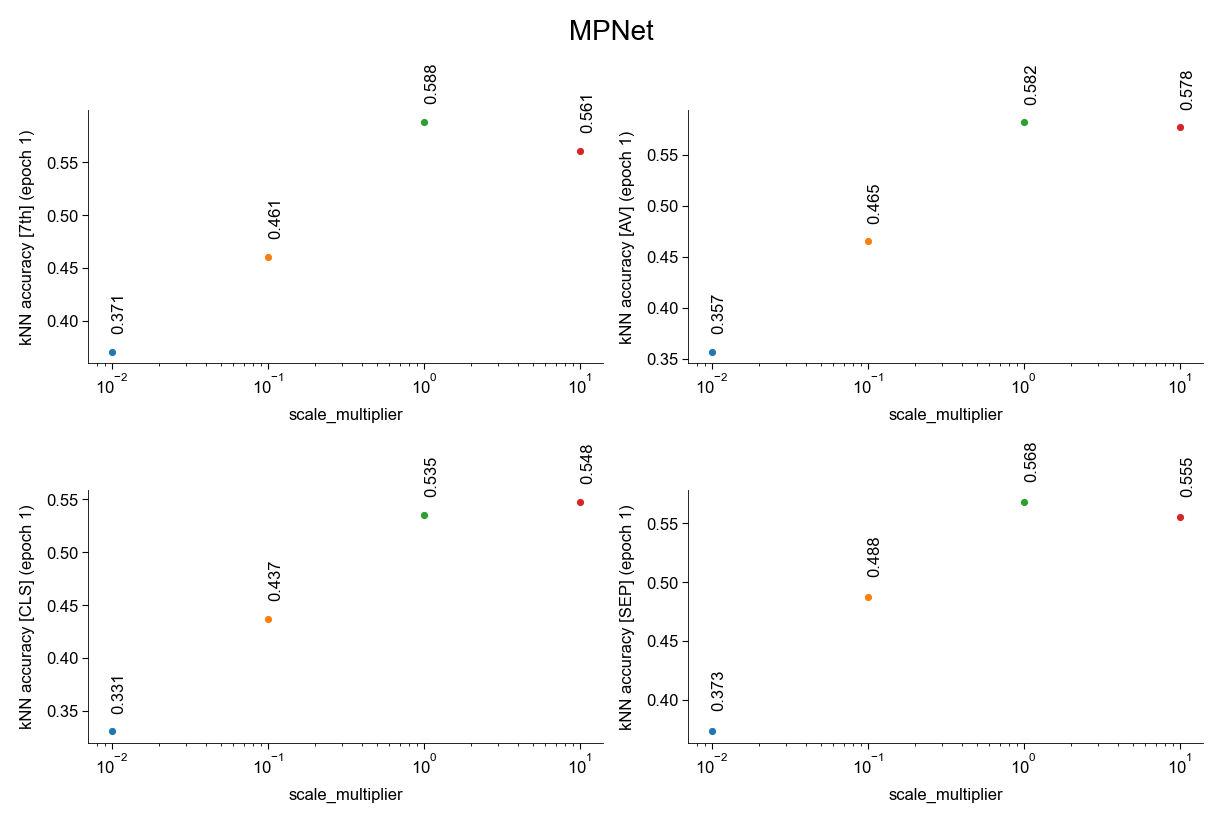

In [ ]:
%matplotlib inline

# for i, model_name in enumerate(model_names):
fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 1
colormap = plt.get_cmap("tab10")
multipliers = np.array([0.01, 0.1, 1, 10])
for j, mult in enumerate(multipliers):
    i = 1
    model_name = model_names[i]

    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    saving_name_losses = Path(
        f"losses_7th_scale_multiplier_{mult}" + "_v1.npy"
    )
    saving_name_accuracies = Path(
        f"knn_accuracies_7th_scale_multiplier_{mult}" + "_v1.npy"
    )

    losses = np.load(variables_path / saving_path / saving_name_losses)
    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies
    )


    ## plot
    color = colormap(j)

    # 7th
    axs[0, 0].scatter(
        mult,
        knn_accuracies[-1, 3],
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )
    axs[0, 0].text(
        mult,
        knn_accuracies[-1, 3] + 0.02,
        f"{knn_accuracies[-1, 3]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[0, 0].set_xlabel("scale_multiplier")
    axs[0, 0].set_xscale("log")
    axs[0, 0].set_xticks(multipliers)
    axs[0, 0].set_ylabel("kNN accuracy [7th] (epoch 1)")

    # AV
    axs[0, 1].scatter(
        mult,
        knn_accuracies[-1, 0],
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )
    axs[0, 1].text(
        mult,
        knn_accuracies[-1, 0] + 0.02,
        f"{knn_accuracies[-1, 0]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[0, 1].set_xlabel("scale_multiplier")
    axs[0, 1].set_xscale("log")
    axs[0, 1].set_xticks(multipliers)
    axs[0, 1].set_ylabel("kNN accuracy [AV] (epoch 1)")

    # CLS
    axs[1, 0].scatter(
        mult,
        knn_accuracies[-1, 1],
        s=10,
        label=f"scale_multiplier = {mult}",
        color=color,
    )
    axs[1, 0].text(
        mult,
        knn_accuracies[-1, 1] + 0.02,
        f"{knn_accuracies[-1, 1]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[1, 0].set_xlabel("scale_multiplier")
    axs[1, 0].set_xscale("log")
    axs[1, 0].set_xticks(multipliers)
    axs[1, 0].set_ylabel("kNN accuracy [CLS] (epoch 1)")

    # SEP
    axs[1, 1].scatter(
        mult,
        knn_accuracies[-1, 2],
        label=f"scale_multiplier = {mult}",
        color=color,
        s=10,
    )
    axs[1, 1].text(
        mult,
        knn_accuracies[-1, 2] + 0.02,
        f"{knn_accuracies[-1, 2]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    
    axs[1, 1].set_xlabel("scale_multiplier")
    axs[1, 1].set_xscale("log")
    axs[1, 1].set_xticks(multipliers)
    axs[1, 1].set_ylabel("kNN accuracy [SEP] (epoch 1)")

fig.suptitle(f"{model_name}", fontsize=10)

fig.savefig(
    figures_path
    / f"loss_and_knn_accuracy_7th_scale_multiplier_{model_name}_v1.png"
)

## Combined plot

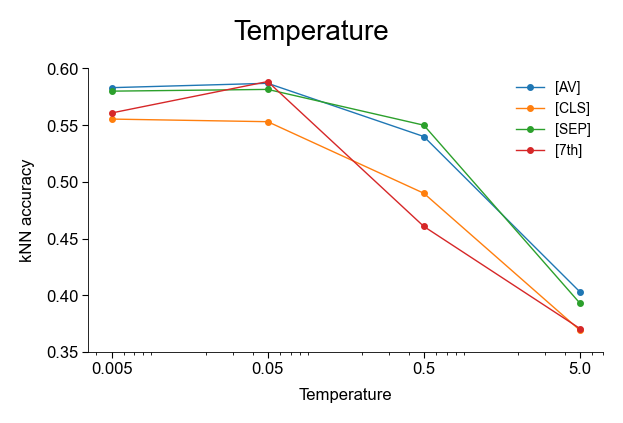

In [ ]:
%matplotlib inline

# for i, model_name in enumerate(model_names):
fig, ax = plt.subplots(figsize=(3, 2), dpi=200, layout="constrained")
n_epochs = 1
colormap = plt.get_cmap("tab10")
multipliers = np.array([0.01, 0.1, 1, 10])
knn_accuracies_av_all = []
knn_accuracies_cls_all = []
knn_accuracies_sep_all = []
knn_accuracies_7th_all = []

for j, mult in enumerate(multipliers):
    i = 1
    model_name = model_names[i]
    # LOAD
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    # AV
    saving_name_accuracies = Path(
        f"knn_accuracies_av_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # CLS
    saving_name_accuracies = Path(
        f"knn_accuracies_cls_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # SEP
    saving_name_accuracies = Path(
        f"knn_accuracies_sep_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_sep = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # 7th
    saving_name_accuracies = Path(
        f"knn_accuracies_7th_scale_multiplier_{mult}" + "_v1.npy"
    )
    knn_accuracies_7th = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])
    knn_accuracies_sep_all.append(knn_accuracies_sep[-1, 2])
    knn_accuracies_7th_all.append(knn_accuracies_7th[-1, 3])

s_chosen = 3

ax.plot(
    1 / (multipliers * 20),
    knn_accuracies_av_all,
    label=f"[AV]",
    # color="tab:blue",
    ms=s_chosen,
    marker=".",
)
ax.plot(
    1 / (multipliers * 20),
    knn_accuracies_cls_all,
    # color="tab:orange",
    label=f"[CLS]",
    ms=s_chosen,
    marker=".",
)
ax.plot(
    1 / (multipliers * 20),
    knn_accuracies_sep_all,
    # color="tab:orange",
    label=f"[SEP]",
    ms=s_chosen,
    marker=".",
)
ax.plot(
    1 / (multipliers * 20),
    knn_accuracies_7th_all,
    # color="tab:orange",
    label=f"[7th]",
    ms=s_chosen,
    marker=".",
)

ax.set_ylim(0.35, 0.6)
ax.set_xlabel("Temperature")
ax.set_xscale("log")
ax.set_xticks(1 / (multipliers * 20))
ax.set_xticklabels(1 / (multipliers * 20))
ax.set_ylabel("kNN accuracy")
ax.legend()


fig.suptitle(f"Temperature", fontsize=10)

fig.savefig(
    figures_path
    / f"loss_and_knn_accuracy_all_reps_scale_multiplier_{model_name}_v1.png"
)

# Number of sentences
Varying n_cons_sntcs in MultOverlappingSentencesPairDataset


## [CLS]

In [ ]:
%%time
batch_sizes = [
    128,
    64,
    64,
    64,
    32,
    32,
    32,
    32,
    32,
    16,
]  # checked manually that those are the maximal batch sizes allowed bc of memory

for j, n_cons_sntcs in enumerate(np.arange(1, 11)):
    i = 1
    model_name = model_names[i]
    batchsize = batch_sizes[j]
    print("Number of consecutive sentences: ", n_cons_sntcs)
    print("with batch size = ", batchsize)

    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=n_cons_sntcs
    )
    # print(n)
    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batchsize, shuffle=True, generator=gen
    )
    print("Number of contrastive pairs: ", len(training_loader))

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="cls",
        n_epochs=1,
        lr=2e-5,
        return_seventh=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)
    saving_name_losses = Path(
        "losses_cls_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1"
    )
    saving_name_accuracies = Path(
        "knn_accuracies_cls_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Number of consecutive sentences:  1
with batch size =  128


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  189


  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  2
with batch size =  64


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  368


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  3
with batch size =  64


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  341


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  4
with batch size =  64


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  291


  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  5
with batch size =  32


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  434


  0%|          | 0/434 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  6
with batch size =  32


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  276


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  7
with batch size =  32


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  152


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  8
with batch size =  32


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  71


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  9
with batch size =  32


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  10
with batch size =  16


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  19


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 1h 11min 48s, sys: 1h 4min 48s, total: 2h 16min 36s
Wall time: 1h 14min 20s


### Plot

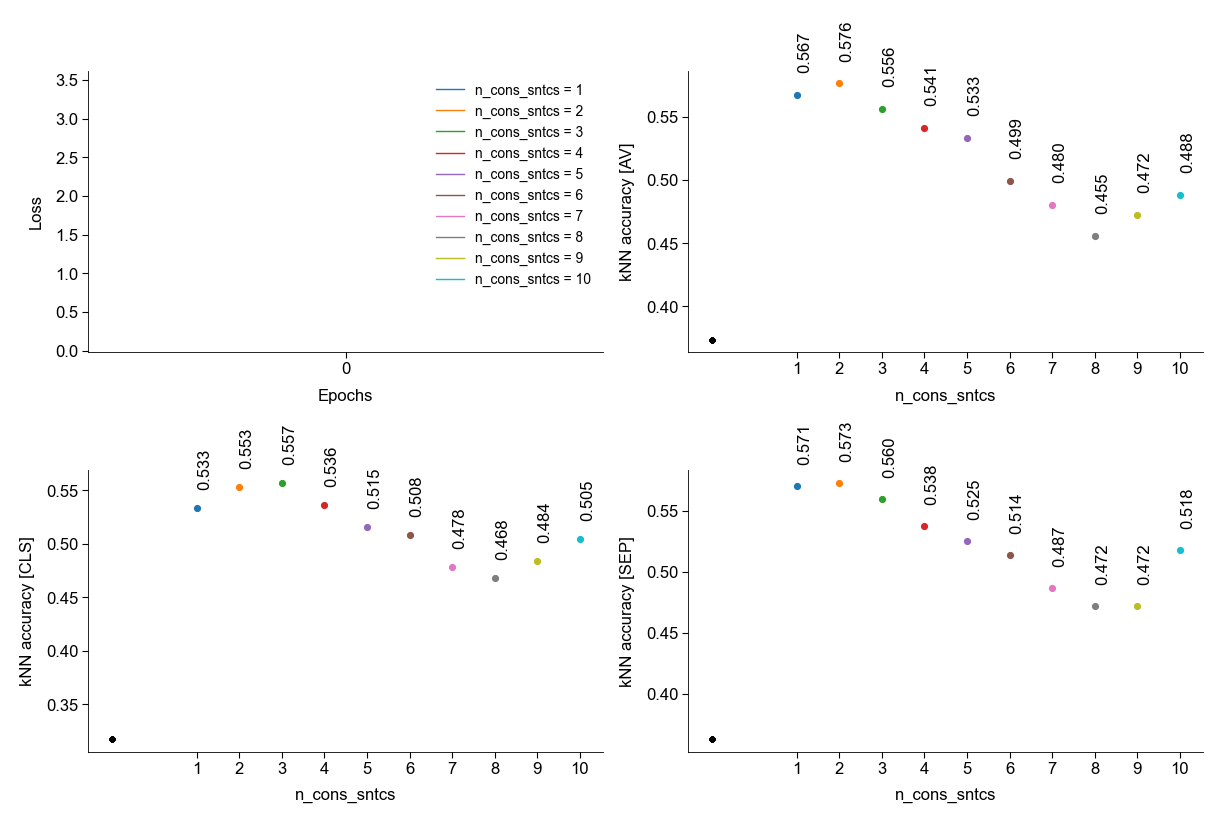

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 1
colormap = plt.get_cmap("tab10")

batch_sizes = [
    128,
    64,
    64,
    64,
    32,
    32,
    32,
    32,
    32,
    16,
] 

for j, n_cons_sntcs in enumerate(np.arange(1, 11)):
    batchsize = batch_sizes[j]
    i = 1
    model_name = model_names[i]

    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    saving_name_losses = Path(
        "losses_cls_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1.npy"
    )
    saving_name_accuracies = Path(
        "knn_accuracies_cls_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1.npy"
    )

    losses = np.load(variables_path / saving_path / saving_name_losses)
    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    saving_name_2 = Path(
        "updated_dataset/knn_accuracy_" + model_name.lower() + ".npy"
    )
    knn_acc_highd = np.load(variables_path / saving_name_2)

    color = colormap(j)

    # losses
    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label="n_cons_sntcs = " + str(n_cons_sntcs),
    )
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    # AV
    axs[0, 1].scatter(
        n_cons_sntcs,
        knn_accuracies[-1, 0],
        label="n_cons_sntcs = " + str(n_cons_sntcs),
        color=color,
        s=10,
    )
    axs[0, 1].text(
        n_cons_sntcs,
        knn_accuracies[-1, 0] + 0.02,
        f"{knn_accuracies[-1, 0]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[0, 1].scatter(-1, knn_acc_highd[0], s=5, c="k")
    axs[0, 1].set_xticks(np.arange(1, 11))
    # axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("n_cons_sntcs")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")

    #   CLS
    axs[1, 0].scatter(
        n_cons_sntcs,
        knn_accuracies[-1, 1],
        s=10,
        label="n_cons_sntcs = " + str(n_cons_sntcs),
        color=color,
    )
    axs[1, 0].text(
        n_cons_sntcs,
        knn_accuracies[-1, 1] + 0.02,
        f"{knn_accuracies[-1, 1]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[1, 0].scatter(-1, knn_acc_highd[1], s=5, c="k")
    axs[1, 0].set_xticks(np.arange(1, 11))
    # axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("n_cons_sntcs")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")

    # SEP
    axs[1, 1].scatter(
        n_cons_sntcs,
        knn_accuracies[-1, 2],
        label="n_cons_sntcs = " + str(n_cons_sntcs),
        color=color,
        s=10,
    )
    axs[1, 1].text(
        n_cons_sntcs,
        knn_accuracies[-1, 2] + 0.02,
        f"{knn_accuracies[-1, 2]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[1, 1].scatter(-1, knn_acc_highd[2], s=5, c="k")
    axs[1, 1].set_xticks(np.arange(1, 11))
    # axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("n_cons_sntcs")
    axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(figures_path / "loss_and_knn_accuracy_cls_n_cons_sntcs_v1.png")

## [AV]

In [ ]:
%%time
batch_sizes = [
    128,
    64,
    64,
    64,
    32,
    32,
    32,
    32,
    32,
    16,
]  # checked manually that those are the maximal batch sizes allowed bc of memory

for j, n_cons_sntcs in enumerate(np.arange(1, 11)):
    i = 1
    model_name = model_names[i]
    batchsize = batch_sizes[j]
    print("Number of consecutive sentences: ", n_cons_sntcs)
    print("with batch size = ", batchsize)

    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=n_cons_sntcs
    )
    # print(n)
    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=batchsize, shuffle=True, generator=gen
    )
    print("Number of contrastive pairs: ", len(training_loader))

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=1,
        lr=2e-5,
        return_seventh=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)
    saving_name_losses = Path(
        "losses_av_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1"
    )
    saving_name_accuracies = Path(
        "knn_accuracies_av_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Number of consecutive sentences:  1
with batch size =  128


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  189


  0%|          | 0/189 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  2
with batch size =  64


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  368


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  3
with batch size =  64


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  341


  0%|          | 0/341 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  4
with batch size =  64


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  291


  0%|          | 0/291 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  5
with batch size =  32


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  434


  0%|          | 0/434 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  6
with batch size =  32


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  276


  0%|          | 0/276 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  7
with batch size =  32


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  152


  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  8
with batch size =  32


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  71


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  9
with batch size =  32


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  28


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Number of consecutive sentences:  10
with batch size =  16


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  19


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 1h 13min 52s, sys: 1h 4min 10s, total: 2h 18min 2s
Wall time: 1h 14min 11s


### Plot

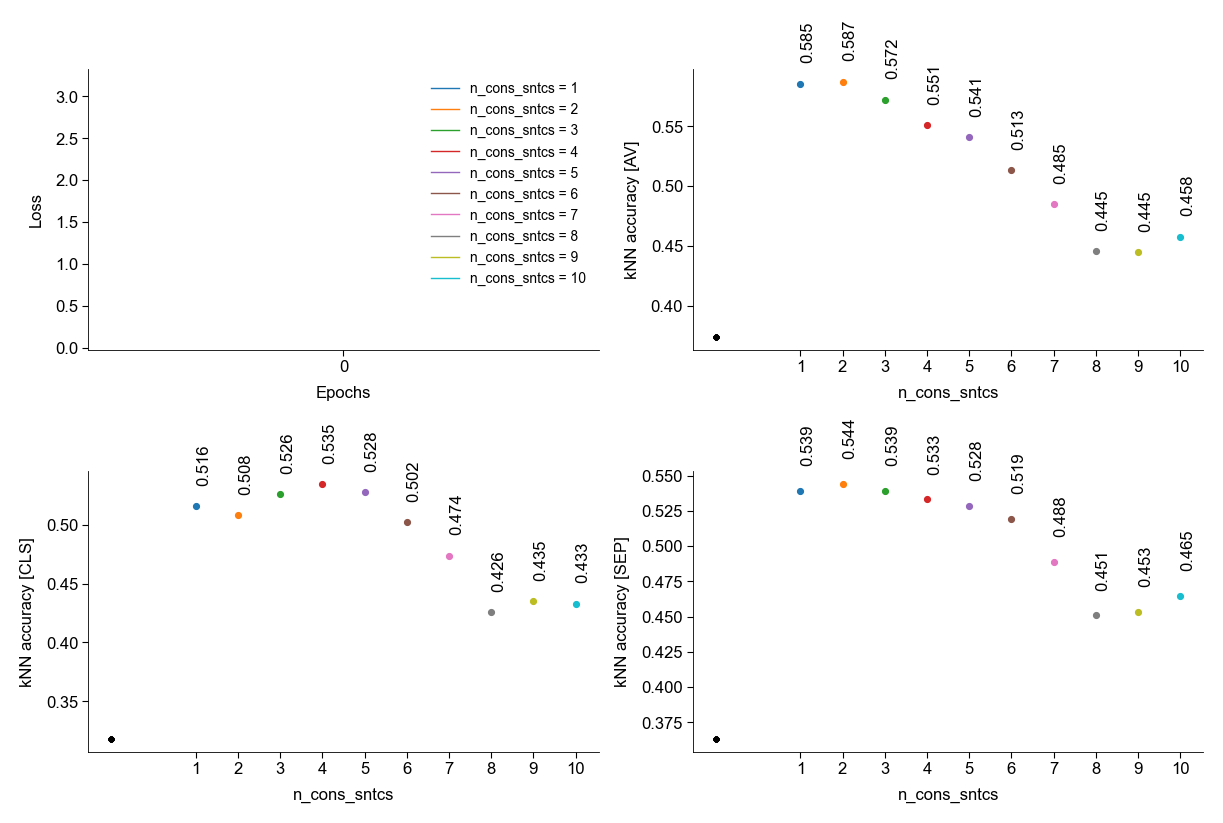

In [ ]:
%matplotlib inline

fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 1
colormap = plt.get_cmap("tab10")

batch_sizes = [
    128,
    64,
    64,
    64,
    32,
    32,
    32,
    32,
    32,
    16,
]  

for j, n_cons_sntcs in enumerate(np.arange(1, 11)):
    batchsize = batch_sizes[j]
    i = 1
    model_name = model_names[i]

    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    saving_name_losses = Path(
        "losses_av_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1.npy"
    )
    saving_name_accuracies = Path(
        "knn_accuracies_av_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1.npy"
    )

    losses = np.load(variables_path / saving_path / saving_name_losses)
    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    saving_name_2 = Path(
        "updated_dataset/knn_accuracy_" + model_name.lower() + ".npy"
    )
    knn_acc_highd = np.load(variables_path / saving_name_2)

    color = colormap(j)

    # losses
    axs[0, 0].plot(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label="n_cons_sntcs = " + str(n_cons_sntcs),
    )
    axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    # AV
    axs[0, 1].scatter(
        n_cons_sntcs,
        knn_accuracies[-1, 0],
        label="n_cons_sntcs = " + str(n_cons_sntcs),
        color=color,
        s=10,
    )
    axs[0, 1].text(
        n_cons_sntcs,
        knn_accuracies[-1, 0] + 0.02,
        f"{knn_accuracies[-1, 0]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[0, 1].scatter(-1, knn_acc_highd[0], s=5, c="k")
    axs[0, 1].set_xticks(np.arange(1, 11))
    # axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("n_cons_sntcs")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")

    #   CLS
    axs[1, 0].scatter(
        n_cons_sntcs,
        knn_accuracies[-1, 1],
        s=10,
        label="n_cons_sntcs = " + str(n_cons_sntcs),
        color=color,
    )
    axs[1, 0].text(
        n_cons_sntcs,
        knn_accuracies[-1, 1] + 0.02,
        f"{knn_accuracies[-1, 1]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[1, 0].scatter(-1, knn_acc_highd[1], s=5, c="k")
    axs[1, 0].set_xticks(np.arange(1, 11))
    # axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("n_cons_sntcs")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")

    # SEP
    axs[1, 1].scatter(
        n_cons_sntcs,
        knn_accuracies[-1, 2],
        label="n_cons_sntcs = " + str(n_cons_sntcs),
        color=color,
        s=10,
    )
    axs[1, 1].text(
        n_cons_sntcs,
        knn_accuracies[-1, 2] + 0.02,
        f"{knn_accuracies[-1, 2]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    axs[1, 1].scatter(-1, knn_acc_highd[2], s=5, c="k")
    axs[1, 1].set_xticks(np.arange(1, 11))
    # axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("n_cons_sntcs")
    axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.savefig(figures_path / "loss_and_knn_accuracy_av_n_cons_sntcs_v1.png")

### Combined plot

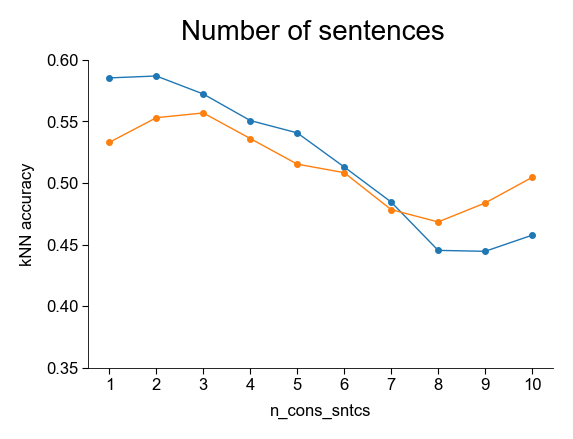

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 2), dpi=200)
n_epochs = 1
colormap = plt.get_cmap("tab10")

batch_sizes = [
    128,
    64,
    64,
    64,
    32,
    32,
    32,
    32,
    32,
    16,
]
knn_accuracies_av_all = []
knn_accuracies_cls_all = []

for j, n_cons_sntcs in enumerate(np.arange(1, 11)):
    batchsize = batch_sizes[j]
    i = 1
    model_name = "MPNet"

    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    saving_name_accuracies = Path(
        "knn_accuracies_av_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    saving_name_accuracies = Path(
        "knn_accuracies_cls_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_"
        + str(batchsize)
        + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])


    # AV
s_chosen = 3
ax.plot(
    np.arange(1, 11),
    knn_accuracies_av_all,
    # label="n_cons_sntcs = " + str(n_cons_sntcs),
    color="tab:blue",
    ms=s_chosen,
    marker=".",
)
ax.plot(
    np.arange(1, 11),
    knn_accuracies_cls_all,
    # label="n_cons_sntcs = " + str(n_cons_sntcs),
    color="tab:orange",
    ms=s_chosen,
    marker=".",
)

ax.set_xticks(np.arange(1, 11))
ax.set_ylim(0.35, 0.6)
ax.set_xlabel("n_cons_sntcs")
ax.set_ylabel("kNN accuracy")
ax.legend(loc="upper right")


fig.suptitle(f"Number of sentences", fontsize=10)


fig.savefig(
    figures_path / "loss_and_knn_accuracy_av_and_cls_n_cons_sntcs_v2.png"
)

# Fraction masked tokens
Varying fraction_masked in MaskedMultOverlappingSentencesPairDataset

## [CLS]

In [ ]:
model_names = [
    "BERT",
    "MPNet",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
]

In [ ]:
%%time

fraction_masked_values = np.arange(0.1, 0.9, 0.1)
for j, frct in enumerate(fraction_masked_values):
    # model
    i = 1
    model_name = model_names[i]

    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)
    print("Fraction of masked tokens: ", frct)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    n_cons_sntcs = 2
    training_dataset = MaskedMultOverlappingSentencesPairDataset(
        iclr2024.abstract,
        tokenizer,
        device,
        n_cons_sntcs=n_cons_sntcs,
        fraction_masked=frct,
        seed=42,
    )
    gen = torch.Generator()
    gen.manual_seed(seed)

    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="cls",
        n_epochs=1,
        lr=2e-5,
        return_seventh=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)
    saving_name_losses = Path(
        f"losses_cls_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1"
    )
    saving_name_accuracies = Path(
        f"knn_accuracies_cls_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  MPNet
Fraction of masked tokens:  0.1
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.2
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.30000000000000004
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.4
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.5
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.6
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.7000000000000001
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.8
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 1h 16min 39s, sys: 1h 2min 30s, total: 2h 19min 10s
Wall time: 1h 14min 4s


### Plot

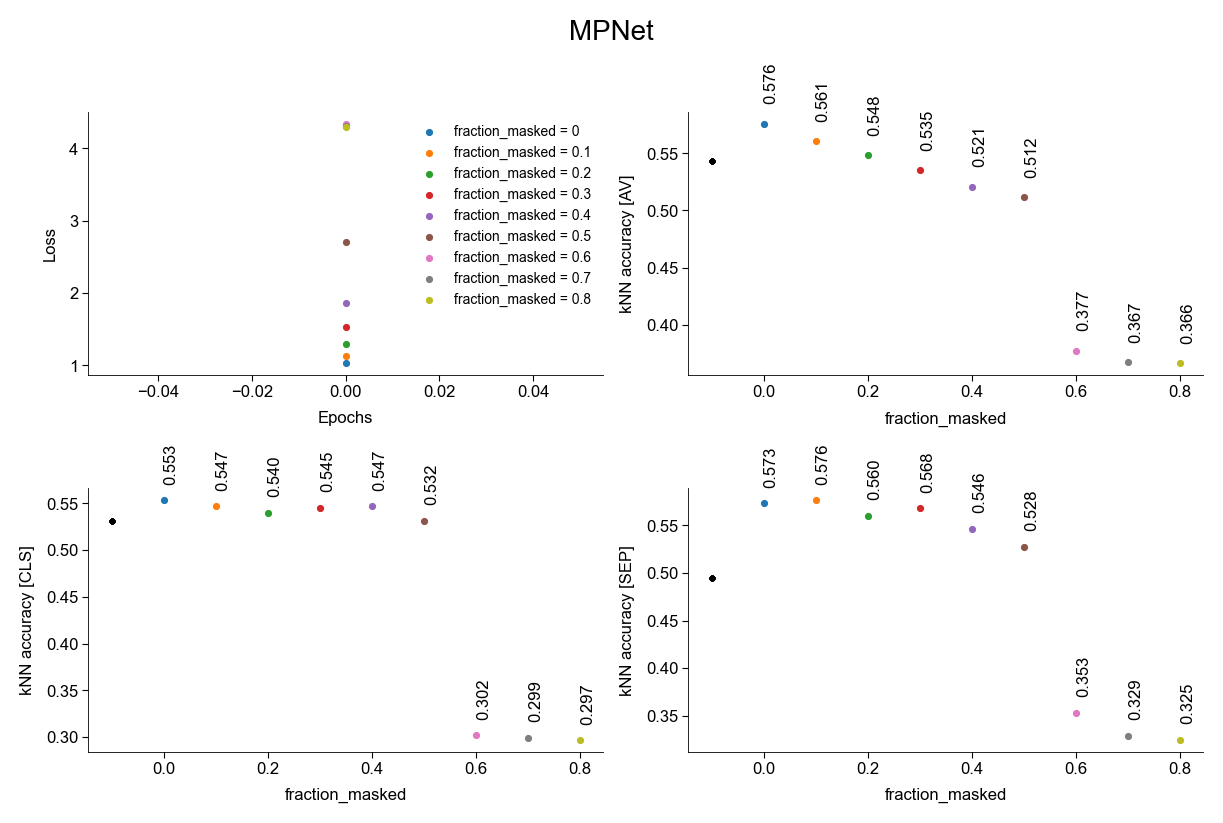

In [ ]:
%matplotlib inline


fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 1
colormap = plt.get_cmap("tab10")
fraction_masked_values = np.arange(0.1, 0.9, 0.1)
for j, frct in enumerate(fraction_masked_values):
    i = 1
    model_name = model_names[i]
    n_cons_sntcs = 2

    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    saving_name_losses = Path(
        f"losses_cls_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1.npy"
    )
    saving_name_accuracies = Path(
        f"knn_accuracies_cls_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1.npy"
    )

    losses = np.load(variables_path / saving_path / saving_name_losses)
    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # fraction = 0
    saving_name_losses = Path(
        "losses_cls_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_64_v1.npy"
    )
    saving_name_accuracies = Path(
        "knn_accuracies_cls_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_64_v1.npy"
    )

    losses_cls_fraction_masked_0 = np.load(
        variables_path / saving_path / saving_name_losses
    )
    knn_accuracies_cls_fraction_masked_0 = np.load(
        variables_path / saving_path / saving_name_accuracies
    ).reshape(
        -1,
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / saving_name_2)

    color = colormap(j + 1)
    # losses
    if j == 0:
        axs[0, 0].scatter(
            np.arange(n_epochs),
            np.mean(losses_cls_fraction_masked_0, axis=1),
            label="fraction_masked = 0",
            s=10,
        )
    axs[0, 0].scatter(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=f"fraction_masked = {frct:.1f}",
        s=10,
    )
    # axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    # AV
    axs[0, 1].scatter(
        frct,
        knn_accuracies[-1, 0],
        label="fraction_masked = " + str(frct),
        color=color,
        s=10,
    )
    axs[0, 1].text(
        frct,
        knn_accuracies[-1, 0] + 0.02,
        f"{knn_accuracies[-1, 0]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    if j == 0:
        axs[0, 1].scatter(
            0,
            knn_accuracies_cls_fraction_masked_0[0],
            label="fraction_masked = 0",
            # color=color,
            s=10,
        )
        axs[0, 1].text(
            0,
            knn_accuracies_cls_fraction_masked_0[0] + 0.02,
            f"{knn_accuracies_cls_fraction_masked_0[0]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    axs[0, 1].scatter(-0.1, knn_acc_highd[0], s=5, c="k")
    # axs[0, 1].set_xticks(np.arange(n_epochs))
    # axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("fraction_masked")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")

    # CLS
    axs[1, 0].scatter(
        frct,
        knn_accuracies[-1, 1],
        s=10,
        label="fraction_masked = " + str(frct),
        color=color,
    )
    axs[1, 0].text(
        frct,
        knn_accuracies[-1, 1] + 0.02,
        f"{knn_accuracies[-1, 1]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    if j == 0:
        axs[1, 0].scatter(
            0,
            knn_accuracies_cls_fraction_masked_0[1],
            label="fraction_masked = 0",
            # color=color,
            s=10,
        )
        axs[1, 0].text(
            0,
            knn_accuracies_cls_fraction_masked_0[1] + 0.02,
            f"{knn_accuracies_cls_fraction_masked_0[1]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    axs[1, 0].scatter(-0.1, knn_acc_highd[1], s=5, c="k")
    # axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("fraction_masked")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")

    # SEP
    axs[1, 1].scatter(
        frct,
        knn_accuracies[-1, 2],
        label="fraction_masked = " + str(frct),
        color=color,
        s=10,
    )
    axs[1, 1].text(
        frct,
        knn_accuracies[-1, 2] + 0.02,
        f"{knn_accuracies[-1, 2]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    if j == 0:
        axs[1, 1].scatter(
            0,
            knn_accuracies_cls_fraction_masked_0[2],
            label="fraction_masked = 0",
            # color=color,
            s=10,
        )
        axs[1, 1].text(
            0,
            knn_accuracies_cls_fraction_masked_0[2] + 0.02,
            f"{knn_accuracies_cls_fraction_masked_0[2]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    axs[1, 1].scatter(-0.1, knn_acc_highd[2], s=5, c="k")
    # axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("fraction_masked")
    axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.suptitle(f"{model_name}", fontsize=10)

fig.savefig(
    figures_path
    / f"loss_and_knn_accuracy_cls_fraction_masked_n_cons_sntcs_2_{model_name}_v1.png"
)

## [AV]

In [ ]:
model_names = [
    "BERT",
    "MPNet",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
]

In [ ]:
%%time

fraction_masked_values = np.arange(0.1, 0.9, 0.1)
for j, frct in enumerate(fraction_masked_values):
    # model
    i = 1
    model_name = model_names[i]

    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms(True)
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    print("Model: ", model_name)
    print("Fraction of masked tokens: ", frct)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Running on device: {}".format(device))

    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])
    print(model_paths[i])

    # data
    n_cons_sntcs = 2
    training_dataset = MaskedMultOverlappingSentencesPairDataset(
        iclr2024.abstract,
        tokenizer,
        device,
        n_cons_sntcs=n_cons_sntcs,
        fraction_masked=frct,
        seed=42,
    )
    gen = torch.Generator()
    gen.manual_seed(seed)

    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=1,
        lr=2e-5,
        return_seventh=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)
    saving_name_losses = Path(
        f"losses_av_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1"
    )
    saving_name_accuracies = Path(
        f"knn_accuracies_av_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Model:  MPNet
Fraction of masked tokens:  0.1
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.2
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.30000000000000004
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.4
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.5
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.6
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.7000000000000001
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
Model:  MPNet
Fraction of masked tokens:  0.8
Running on device: cuda


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


microsoft/mpnet-base


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

----------------------------
CPU times: user 1h 16min 54s, sys: 1h 2min 3s, total: 2h 18min 57s
Wall time: 1h 13min 45s


### Plot

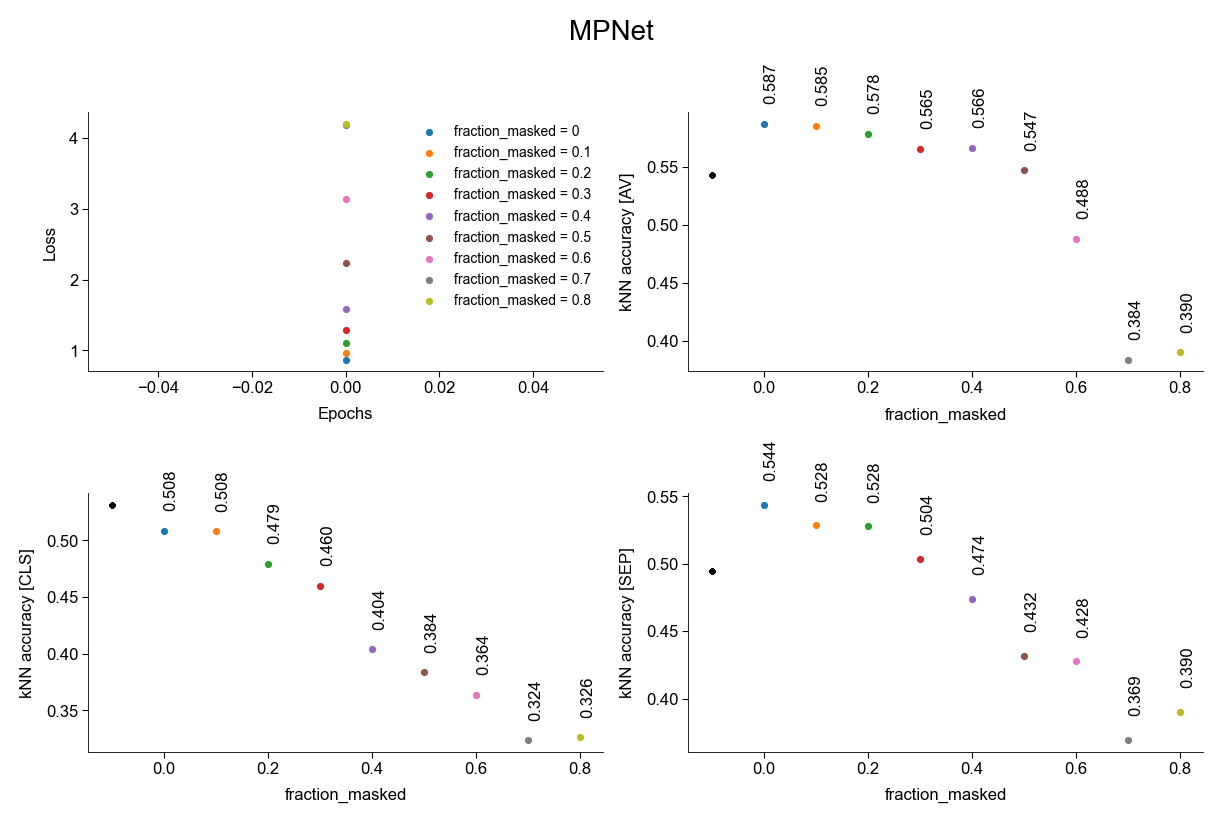

In [ ]:
%matplotlib inline

# for i, model_name in enumerate(model_names):
fig, axs = plt.subplots(2, 2, figsize=(6, 4), dpi=200)
n_epochs = 1
colormap = plt.get_cmap("tab10")
fraction_masked_values = np.arange(0.1, 0.9, 0.1)
for j, frct in enumerate(fraction_masked_values):
    i = 1
    model_name = model_names[i]
    n_cons_sntcs = 2

    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    saving_name_losses = Path(
        f"losses_av_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1.npy"
    )
    saving_name_accuracies = Path(
        f"knn_accuracies_av_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1.npy"
    )

    losses = np.load(variables_path / saving_path / saving_name_losses)
    knn_accuracies = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    # fraction = 0
    saving_name_losses = Path(
        "losses_av_n_cons_sntcs_" + str(n_cons_sntcs) + "_batch_size_64_v1.npy"
    )
    saving_name_accuracies = Path(
        "knn_accuracies_av_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_batch_size_64_v1.npy"
    )

    losses_av_fraction_masked_0 = np.load(
        variables_path / saving_path / saving_name_losses
    )
    knn_accuracies_av_fraction_masked_0 = np.load(
        variables_path / saving_path / saving_name_accuracies
    ).reshape(
        -1,
    )

    saving_name_2 = Path("knn_accuracy_" + model_name.lower() + ".npy")
    knn_acc_highd = np.load(variables_path / saving_name_2)

    color = colormap(j + 1)
    # losses
    if j == 0:
        axs[0, 0].scatter(
            np.arange(n_epochs),
            np.mean(losses_av_fraction_masked_0, axis=1),
            label="fraction_masked = 0",
            s=10,
        )
    axs[0, 0].scatter(
        np.arange(n_epochs),
        np.mean(losses, axis=1),
        label=f"fraction_masked = {frct:.1f}",
        s=10,
    )
    # axs[0, 0].set_xticks(np.arange(n_epochs))
    axs[0, 0].set_xlabel("Epochs")
    axs[0, 0].set_ylabel("Loss")
    axs[0, 0].legend()

    # AV
    axs[0, 1].scatter(
        frct,
        knn_accuracies[-1, 0],
        label="fraction_masked = " + str(frct),
        color=color,
        s=10,
    )
    axs[0, 1].text(
        frct,
        knn_accuracies[-1, 0] + 0.02,
        f"{knn_accuracies[-1, 0]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    if j == 0:
        axs[0, 1].scatter(
            0,
            knn_accuracies_av_fraction_masked_0[0],
            label="fraction_masked = 0",
            # color=color,
            s=10,
        )
        axs[0, 1].text(
            0,
            knn_accuracies_av_fraction_masked_0[0] + 0.02,
            f"{knn_accuracies_av_fraction_masked_0[0]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    axs[0, 1].scatter(-0.1, knn_acc_highd[0], s=5, c="k")
    # axs[0, 1].set_xticks(np.arange(n_epochs))
    # axs[0, 1].set_ylim(0.35, 0.85)
    axs[0, 1].set_xlabel("fraction_masked")
    axs[0, 1].set_ylabel("kNN accuracy [AV]")

    # CLS
    axs[1, 0].scatter(
        frct,
        knn_accuracies[-1, 1],
        s=10,
        label="fraction_masked = " + str(frct),
        color=color,
    )
    axs[1, 0].text(
        frct,
        knn_accuracies[-1, 1] + 0.02,
        f"{knn_accuracies[-1, 1]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    if j == 0:
        axs[1, 0].scatter(
            0,
            knn_accuracies_av_fraction_masked_0[1],
            label="fraction_masked = 0",
            # color=color,
            s=10,
        )
        axs[1, 0].text(
            0,
            knn_accuracies_av_fraction_masked_0[1] + 0.02,
            f"{knn_accuracies_av_fraction_masked_0[1]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    axs[1, 0].scatter(-0.1, knn_acc_highd[1], s=5, c="k")
    # axs[1, 0].set_xticks(np.arange(n_epochs))
    # axs[1, 0].set_ylim(0.35, 0.85)
    axs[1, 0].set_xlabel("fraction_masked")
    axs[1, 0].set_ylabel("kNN accuracy [CLS]")

    # SEP
    axs[1, 1].scatter(
        frct,
        knn_accuracies[-1, 2],
        label="fraction_masked = " + str(frct),
        color=color,
        s=10,
    )
    axs[1, 1].text(
        frct,
        knn_accuracies[-1, 2] + 0.02,
        f"{knn_accuracies[-1, 2]:.3f}",
        rotation="vertical",
        fontsize=6,
    )
    if j == 0:
        axs[1, 1].scatter(
            0,
            knn_accuracies_av_fraction_masked_0[2],
            label="fraction_masked = 0",
            # color=color,
            s=10,
        )
        axs[1, 1].text(
            0,
            knn_accuracies_av_fraction_masked_0[2] + 0.02,
            f"{knn_accuracies_av_fraction_masked_0[2]:.3f}",
            rotation="vertical",
            fontsize=6,
        )
    axs[1, 1].scatter(-0.1, knn_acc_highd[2], s=5, c="k")
    # axs[1, 1].set_xticks(np.arange(n_epochs))
    # axs[1, 1].set_ylim(0.35, 0.85)
    axs[1, 1].set_xlabel("fraction_masked")
    axs[1, 1].set_ylabel("kNN accuracy [SEP]")

fig.suptitle(f"{model_name}", fontsize=10)

fig.savefig(
    figures_path
    / f"loss_and_knn_accuracy_av_fraction_masked_n_cons_sntcs_2_{model_name}_v1.png"
)

### Combined plot

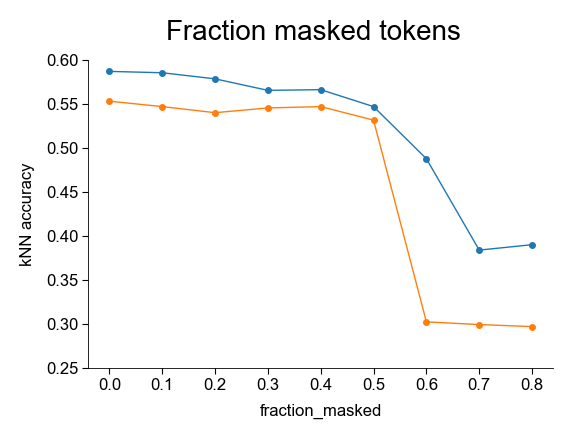

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 2), dpi=200)


knn_accuracies_av_all = []
knn_accuracies_cls_all = []

n_cons_sntcs = 2
model_name = "MPNet"

saving_path = Path("embeddings_" + model_name.lower()) / Path(
    "updated_dataset"
)
saving_name_accuracies = Path(
    "knn_accuracies_av_n_cons_sntcs_"
    + str(n_cons_sntcs)
    + "_batch_size_64_v1.npy"
)
knn_accuracies_av_fraction_masked_0 = np.load(
    variables_path / saving_path / saving_name_accuracies
).reshape(
    -1,
)
saving_name_accuracies = Path(
    "knn_accuracies_cls_n_cons_sntcs_"
    + str(n_cons_sntcs)
    + "_batch_size_64_v1.npy"
)
knn_accuracies_cls_fraction_masked_0 = np.load(
    variables_path / saving_path / saving_name_accuracies
).reshape(
    -1,
)

knn_accuracies_av_all.append(knn_accuracies_av_fraction_masked_0[0])
knn_accuracies_cls_all.append(knn_accuracies_cls_fraction_masked_0[1])

fraction_masked_values = np.arange(0.1, 0.9, 0.1)
for j, frct in enumerate(fraction_masked_values):
    ## AV
    saving_name_accuracies = Path(
        f"knn_accuracies_av_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    ## CLS
    saving_name_accuracies = Path(
        f"knn_accuracies_cls_fraction_masked_{frct:.1f}"
        + "_n_cons_sntcs_"
        + str(n_cons_sntcs)
        + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])


s_chosen = 3

ax.plot(
    np.arange(0, 0.9, 0.1),
    knn_accuracies_av_all,
    # label="fraction_masked = " + str(frct),
    color="tab:blue",
    ms=s_chosen,
    marker=".",
)
ax.plot(
    np.arange(0, 0.9, 0.1),
    knn_accuracies_cls_all,
    # label="fraction_masked = " + str(frct),
    color="tab:orange",
    ms=s_chosen,
    marker=".",
)

ax.set_ylim(0.25, 0.6)
ax.set_xlabel("fraction_masked")
ax.set_ylabel("kNN accuracy")
ax.legend()


fig.suptitle(f"Fraction masked tokens", fontsize=10)

fig.savefig(
    figures_path
    / f"loss_and_knn_accuracy_av_fraction_masked_n_cons_sntcs_2_{model_name}_v3.png"
)

# Learning rate
varying lr, run for 2 epochs instead of 1 to be able to see if there is sth wrong with the loss


In [ ]:
model_names = [
    "BERT",
    "MPNet",
]


model_paths = [
    "bert-base-uncased",
    "microsoft/mpnet-base",
]

## [CLS]

In [ ]:
%%time

learning_rates = [
    1e-3,
    2e-3,
    5e-3,
    1e-4,
    2e-4,
    5e-4,
    1e-5,
    2e-5,
    5e-5,
    1e-6,
    2e-6,
    5e-6,
]

for j, lr in enumerate(learning_rates):
    i = 1
    model_name = model_names[i]


    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2
    )
    # print(n)
    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )
    print("Number of contrastive pairs: ", len(training_loader))

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="cls",
        n_epochs=2,
        lr=lr,
        return_seventh=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)
    saving_name_losses = Path(
        "losses_cls_learning_rate_"
        + str(lr)
        + "_v1"
    )
    saving_name_accuracies = Path(
        "knn_accuracies_cls_learning_rate_"
        + str(lr)
        + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.weight', 'mpnet.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Number of contrastive pairs:  368


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/368 [00:00<?, ?it/s]

## [AV]

In [ ]:
%%time

learning_rates = [
    1e-3,
    2e-3,
    5e-3,
    1e-4,
    2e-4,
    5e-4,
    1e-5,
    2e-5,
    5e-5,
    1e-6,
    2e-6,
    5e-6,
]

for j, lr in enumerate(learning_rates):
    i = 1
    model_name = model_names[i]


    ## fix random seeds
    seed = 42
    # Set the random seed for PyTorch
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    # Set the random seed for NumPy
    np.random.seed(seed)
    # Set the random seed
    random.seed(seed)

    # set up model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_paths[i])
    model = AutoModel.from_pretrained(model_paths[i])

    # data
    training_dataset = MultOverlappingSentencesPairDataset(
        iclr2024.abstract, tokenizer, device, n_cons_sntcs=2
    )
    # print(n)
    gen = torch.Generator()
    gen.manual_seed(seed)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )
    print("Number of contrastive pairs: ", len(training_loader))

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=2,
        lr=lr,
        return_seventh=True,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)
    saving_name_losses = Path(
        "losses_av_learning_rate_"
        + str(lr)
        + "_v1"
    )
    saving_name_accuracies = Path(
        "knn_accuracies_av_learning_rate_"
        + str(lr)
        + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

### Combined plot

1e-06 0.5561538461538461
2e-06 0.5738461538461539
5e-06 0.5823076923076923
1e-05 0.583076923076923
2e-05 0.5876923076923077
5e-05 0.5869230769230769
0.0001 0.5961538461538461
0.0002 0.5992307692307692
0.0005 0.0823076923076923
0.001 0.08923076923076922
0.002 0.055384615384615386
0.005 0.05076923076923077


Text(0.5, 0.98, 'Learning rate')

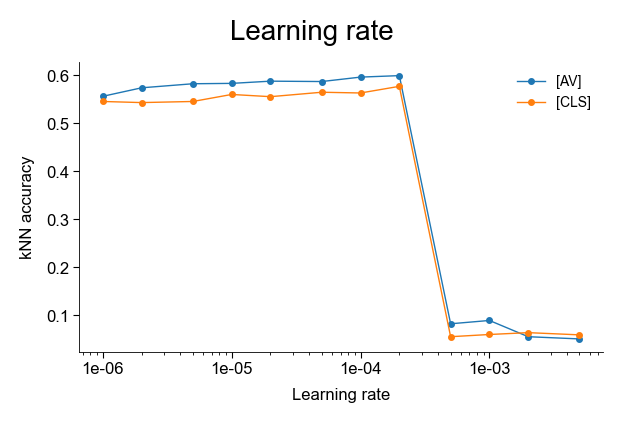

In [ ]:
%matplotlib inline

# for i, model_name in enumerate(model_names):
fig, ax = plt.subplots(figsize=(3, 2), dpi=200, layout="constrained")
n_epochs = 1
colormap = plt.get_cmap("tab10")

knn_accuracies_av_all = []
knn_accuracies_cls_all = []


learning_rates = [
    1e-6,
    2e-6,
    5e-6,
    1e-5,
    2e-5,
    5e-5,
    1e-4,
    2e-4,
    5e-4,
    1e-3,
    2e-3,
    5e-3,
]

for j, lr in enumerate(learning_rates):
    i = 1
    model_name = model_names[i]
    # LOAD
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    # AV
    saving_name_accuracies = Path(
        "knn_accuracies_av_learning_rate_" + str(lr) + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    print(lr, knn_accuracies_av[-1, 0])
    # CLS
    saving_name_accuracies = Path(
        "knn_accuracies_cls_learning_rate_" + str(lr) + "_v1.npy"
    )
    knn_accuracies_cls = np.load(
        variables_path / saving_path / saving_name_accuracies
    )

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])
    knn_accuracies_cls_all.append(knn_accuracies_cls[-1, 1])

s_chosen = 3

ax.plot(
    learning_rates,
    knn_accuracies_av_all,
    label=f"[AV]",
    # color="tab:blue",
    ms=s_chosen,
    marker=".",
)
ax.plot(
    learning_rates,
    knn_accuracies_cls_all,
    # color="tab:orange",
    label=f"[CLS]",
    ms=s_chosen,
    marker=".",
)


# ax.set_ylim(0.35, 0.6)
ax.set_xlabel("Learning rate")
ax.set_xscale("log")
ax.set_xticks(
    [
        1e-6,
        1e-5,
        1e-4,
        1e-3,
    ]
)
# ax.set_xticklabels(learning_rates)
ax.xaxis.set_major_formatter(FormatStrFormatter("%.0e"))
ax.set_ylabel("kNN accuracy")
ax.legend()


fig.suptitle(f"Learning rate", fontsize=10)

# fig.savefig(
#     figures_path / f"knn_accuracy_all_reps_learning_rate_{model_name}_v2.png"
# )

## Dropout
[AV] representation 

In [ ]:
%%time
learning_rates = [
    1e-3,
    2e-3,
    5e-3,
    1e-4,
    2e-4,
    5e-4,
    1e-5,
    2e-5,
    5e-5,
    1e-6,
    2e-6,
    5e-6,
]
model_name = "MPNet"
model_path = "microsoft/mpnet-base"

for j, lr in enumerate(learning_rates):
    ## fix random seeds
    fix_all_seeds()

    # set up model
    device = "cuda" if torch.cuda.is_available() else "cpu"
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)

    # data
    training_dataset = SameSentencePairDataset(
        iclr2024.abstract,
        tokenizer,
        device,
    )

    gen = torch.Generator()
    gen.manual_seed(42)
    training_loader = torch.utils.data.DataLoader(
        training_dataset, batch_size=64, shuffle=True, generator=gen
    )

    # training
    losses, knn_accuracies = train_loop(
        model,
        training_loader,
        device,
        iclr2024.abstract.to_list(),
        tokenizer,
        (labels_iclr != "unlabeled"),
        labels_acc=labels_iclr[labels_iclr != "unlabeled"],
        optimized_rep="av",
        n_epochs=1,
        lr=lr,
        return_seventh=False,
    )

    # save
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    (variables_path / saving_path).mkdir(exist_ok=True)
    saving_name_losses = Path(
        "losses_av_dropout_learning_rate_" + str(lr) + "_v1"
    )
    saving_name_accuracies = Path(
        "knn_accuracies_av_dropout_learning_rate_" + str(lr) + "_v1"
    )

    np.save(variables_path / saving_path / saving_name_losses, losses)
    np.save(
        variables_path / saving_path / saving_name_accuracies,
        knn_accuracies,
    )

    # clean up
    model = None
    tokenizer = None
    gc.collect()
    torch.cuda.empty_cache()

    print("----------------------------")

Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------


Some weights of MPNetModel were not initialized from the model checkpoint at microsoft/mpnet-base and are newly initialized: ['mpnet.pooler.dense.bias', 'mpnet.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/368 [00:00<?, ?it/s]

  0%|          | 0/96 [00:00<?, ?it/s]

----------------------------
CPU times: user 2h 41min 22s, sys: 19min 7s, total: 3h 29s
Wall time: 1h 44min 38s


#### Plot

1e-06 0.46307692307692305
2e-06 0.46923076923076923
5e-06 0.4776923076923077
1e-05 0.46615384615384614
2e-05 0.46923076923076923
5e-05 0.48307692307692307
0.0001 0.4753846153846154
0.0002 0.4469230769230769
0.0005 0.4346153846153846
0.001 0.055384615384615386
0.002 0.14076923076923076
0.005 0.05384615384615385


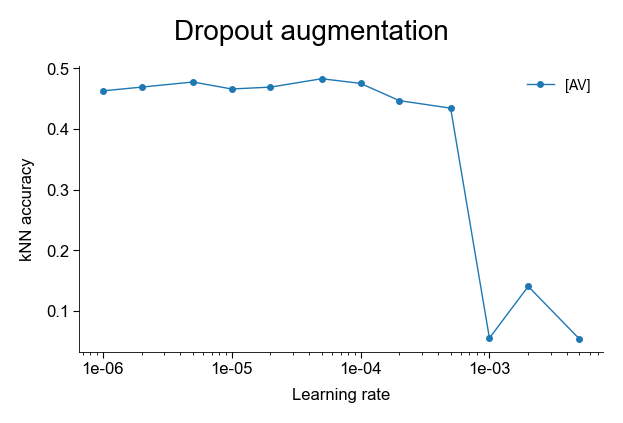

In [ ]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 2), dpi=200, layout="constrained")

knn_accuracies_av_all = []
learning_rates = [
    1e-6,
    2e-6,
    5e-6,
    1e-5,
    2e-5,
    5e-5,
    1e-4,
    2e-4,
    5e-4,
    1e-3,
    2e-3,
    5e-3,
]

for j, lr in enumerate(learning_rates):
    # LOAD
    saving_path = Path("embeddings_" + model_name.lower()) / Path(
        "updated_dataset"
    )
    # AV
    saving_name_accuracies = Path(
        "knn_accuracies_av_dropout_learning_rate_" + str(lr) + "_v1.npy"
    )
    knn_accuracies_av = np.load(
        variables_path / saving_path / saving_name_accuracies
    )
    print(lr, knn_accuracies_av[-1, 0])

    knn_accuracies_av_all.append(knn_accuracies_av[-1, 0])


s_chosen = 3

ax.plot(
    learning_rates,
    knn_accuracies_av_all,
    label=f"[AV]",
    color="tab:blue",
    ms=s_chosen,
    marker=".",
)


# ax.set_ylim(0.35, 0.6)
ax.set_xlabel("Learning rate")
ax.set_xscale("log")
ax.set_xticks(
    [
        1e-6,
        1e-5,
        1e-4,
        1e-3,
    ]
)
# ax.set_xticklabels(learning_rates)
ax.xaxis.set_major_formatter(FormatStrFormatter("%.0e"))
ax.set_ylabel("kNN accuracy")
ax.legend()


fig.suptitle(f"Dropout augmentation", fontsize=10)

fig.savefig(figures_path / f"knn_accuracy_av_dropout_learning_rate_v1.png")